In [1]:
import os
import tqdm
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from argparse import Namespace
from glob import glob

from sklearn.decomposition import PCA

In [2]:
import cv2 as cv

In [3]:
import shapely
import shapely.geometry
import shapely.ops
import rasterio
import rasterio.features
import pycocotools
import pycocotools.mask

In [4]:
from maskrcnn.postprocess.validate import L, gini, plot_scatter

In [5]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [6]:
def gini_series(x): return gini(x.values)

In [7]:
def get_angle(segmentation):
    """Gets the dominant angle (0-90 degrees) of a segmentation mask.
    
    Args:
        segmentation (dict): a COCO format segmentation mask (RLE)

    Returns:
        float: dominant angle, 0 =< angle < 90
    """
    binary_mask = pycocotools.mask.decode(segmentation)
    poly = shapely.ops.unary_union([
        shapely.geometry.shape(geom)
        for geom, val in rasterio.features.shapes(binary_mask, mask=binary_mask)
        if val == 1])
    poly = poly.simplify(3, preserve_topology=False)
    coord_xs, coord_ys = poly.minimum_rotated_rectangle.exterior.xy
    coord_xs = np.array(coord_xs)
    coord_ys = np.array(coord_ys)
    angles = np.arctan2(coord_ys[1:] - coord_ys[:4],
                        coord_xs[1:] - coord_xs[:4]) / np.pi * 180
    angle, = angles[(angles >=0 ) & (angles < 90)]
    return angle

In [8]:
# image index data
IDX_IN_DIR = 'data/Experiment0/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment0/aoi_download_log.csv'

# census data
CEN_IN_DIR = 'data/Experiment0/census.csv'

# satellite derived data
SAT_IN_DIR = 'data/Mexico/Pred/infer/'
SAT_IN_IMG_DIR = 'data/Mexico/Image/'
# output path
OUT_DIR = 'data/Experiment0/Output/'

SAMPLE_NAME = '2019Oct9'

# set up visualization cfg
cfg = Namespace()
cfg.visual_score_cutoff = 0.9
cfg.xmax = 480
cfg.ymax = 770

In [9]:
# renamed columns in census, translate to English
CEN_COLS = {
    'POBTOT': 'cen_pop',
    'VIVTOT': 'cen_house',
    'TVIVHAB': 'cen_inhab',
    'asset_score1': 'cen_asset_score1',
    'asset_score2': 'cen_asset_score2',
    'asset_score3': 'cen_asset_score3',
    'VPH_SNBIEN': 'cen_nodurable',
    'VPH_1CUART': 'cen_1room',
    'VPH_3YMASC': 'cen_3plusroom',
    'VPH_REFRI': 'cen_refri',
    'VPH_AUTOM': 'cen_autom',
    'VPH_C_ELEC': 'cen_elec',
    'VPH_PISODT': 'cen_floor',
    'VPH_AGUADV': 'cen_water',
    'VPH_EXCSA': 'cen_toilet',
    'VPH_DRENAJ': 'cen_drainage',
    'VPH_INTER': 'cen_internet'
}

In [10]:
# read image index data frame
df_idx = pd.merge(pd.read_csv(IDX_IN_DIR),
                  pd.read_csv(LOG_IN_DIR),
                  how='outer', on='index')
df_idx = df_idx.loc[:, ['index', 'ent', 'mun', 'loc', 'chip',
                        'status', 'lon_min', 'lon_max', 'lat_min', 'lat_max']]

In [11]:
# read census data
df_cen = pd.read_csv(CEN_IN_DIR)

# drop NA localities with no images
df_cen = pd.merge(
    df_cen,
    df_idx.groupby(['ent', 'mun', 'loc']).agg(
        no_missing=pd.NamedAgg(column='status',
                               aggfunc=lambda x: sum(pd.isna(x)))),
    how='outer',
    on=['ent', 'mun', 'loc'])
df_cen = df_cen.loc[df_cen['no_missing'] == 0, :]

In [12]:
# compute asset score
vph_cols = [col for col in df_cen.columns if col.startswith('VPH')]
centered = (df_cen.loc[:, vph_cols].values -
            df_cen.loc[:, vph_cols].values.mean(axis=0)[np.newaxis, :])
m = PCA(n_components=3)
df_cen = pd.concat([
    df_cen.reset_index(drop=True),
    pd.DataFrame(m.fit_transform(centered),
                 columns=['asset_score1', 'asset_score2', 'asset_score3'])],
    axis=1)
df_cen['asset_score1'] = - df_cen['asset_score1']

In [17]:
# rename and select columns
df_cen = (df_cen.loc[:, ['ent', 'mun', 'loc', 'sample'] + list(CEN_COLS.keys())]
                .rename(columns=CEN_COLS))

In [18]:
# read satellite predictions
# from json annotations
df_sat = []
for file_name in tqdm.tqdm_notebook(
        glob(SAT_IN_DIR + '*.json')):
    with open(file_name, 'r') as f:
        ann = json.load(f)
    img_file = os.path.join(
        SAT_IN_IMG_DIR,
        (os.path.relpath(file_name, SAT_IN_DIR)
         .replace('.json', '.png')))
    img = cv.imread(img_file)
    img = cv.resize(img, (800, 800))
    for ins in ann:
        binary_mask = pycocotools.mask.decode(ins['segmentation'])
        binary_mask = (binary_mask * 255).astype(np.uint8)
        ins['RGB_mean'] = cv.mean(img, binary_mask)[0:3]
    df_sat += ann
df_sat = pd.DataFrame(df_sat)

In [19]:
# drop low score predictions
df_sat = df_sat.loc[df_sat['score'] > cfg.visual_score_cutoff, :]

# drop predictions on logos
df_sat = pd.concat([
    df_sat.reset_index(drop=True),
    pd.DataFrame(df_sat['bbox'].values.tolist(),
                 columns=['xmin', 'ymin', 'width', 'height'])],
    axis=1)
df_sat = df_sat.loc[~((df_sat['xmin'] > cfg.xmax) & (df_sat['ymin'] > cfg.ymax)), :]

In [20]:
# merge with locality identifiers
df_sat = pd.merge(df_idx, df_sat,
                  how='right', left_on='index', right_on='image_id_str')

In [21]:
# calculate centroid
# remember that the lon/lat min/max are the chip bbox, not the instance bbox
# the following is instance centroid
df_sat['lon_center'] = (df_sat['lon_min'] +
    (df_sat['xmin'] + df_sat['width'] / 2) / 800 *
    (df_sat['lon_max'] - df_sat['lon_min']))
df_sat['lat_center'] = (df_sat['lat_max'] -
    (df_sat['ymin'] + df_sat['height'] / 2) / 800 *
    (df_sat['lat_max'] - df_sat['lat_min']))

In [22]:
df_sat['angle'] = df_sat['segmentation'].apply(get_angle)

In [23]:
df_sat['luminosity'] = df_sat['RGB_mean'].apply(
    lambda x: np.mean([np.max(x[0:3]), np.min(x[0:3])]) / 255)
df_sat['saturation'] = df_sat['RGB_mean'].apply(
    lambda x: ((np.max(x[0:3]) - np.min(x[0:3])) / 255 /
               (1 - np.abs(2 * np.mean([np.max(x[0:3]), np.min(x[0:3])]) / 255 - 1))))

In [24]:
# grouping into localities
df_group = df_sat.groupby(['ent', 'mun', 'loc']).agg(
    sat_house=pd.NamedAgg(column='score', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
    sat_lum_mean=pd.NamedAgg(column='luminosity', aggfunc=np.nanmean),
    sat_saturation_mean=pd.NamedAgg(column='saturation', aggfunc=np.nanmean),
    sat_size_gini=pd.NamedAgg(column='area', aggfunc=gini_series),
    sat_size_sum=pd.NamedAgg(column='area', aggfunc=np.nansum)
)
# calculate K function values
tile_size = 1.6516e-3
for i, col in zip([.5, 1, 1.5],
                  ['sat_dist_h05', 'sat_dist_h10', 'sat_dist_h15']):
    df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
        lambda grp: L(grp[['lon_center', 'lat_center']].values,
                      A=(tile_size ** 2) * 25, h=tile_size * i))

# scale areas / distances
df_group[['sat_size_mean', 'sat_size_sum']] *= (
    ((tile_size / 800 * 111000) ** 2) * np.cos(23 / 180 * np.pi))  # in sq meters

In [25]:
df_group['sat_angle_align'] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
    lambda grp: np.sort(np.histogram(
        grp['angle'].values,
        bins=9, range=(0, 90), density=True)[0] * 10)[-2:].sum())

In [26]:
df_group

sat_house  sat_size_mean  sat_lum_mean  sat_saturation_mean  \
ent mun loc                                                                
3   1   817          3      54.688045      0.637534             0.201711   
4   10  127         67      68.735829      0.835004             0.179827   
5   4   243          2     113.476888      0.656774             0.066380   
    11  153          6      75.200090      0.657462             0.055431   
    24  161          8     145.531993      0.524934             0.038663   
...                ...            ...           ...                  ...   
32  38  63         131      73.123215      0.529901             0.158309   
        210         53      62.461882      0.672886             0.114130   
    43  3            6      58.941918      0.526094             0.091582   
    45  91          16      83.524548      0.545061             0.102133   
    46  22          13      75.019127      0.639495             0.153717   

             sat_size_gini  sat_size_sum  sat_dist_h05  sat_dist_h10  \
ent mun loc                                                            
3   1   817       0.188961    164.064135     -0.000826      0.002153   
4   10  127       0.274074   4605.300567      0.000558      0.000797   
5   4   243       0.137913    226.953775      0.002469      0.001643   
    11  153       0.347404    451.200541      0.001076      0.001038   
    24  161       0.266053   1164.255948      0.001016      0.000678   
...                    ...           ...           ...           ...   
32  38  63        0.311170   9579.141195      0.000214      0.000274   
        210       0.304979   3310.479732      0.000842      0.001055   
    43  3         0.210179    353.651506      0.000727      0.001643   
    45  91        0.267679   1336.392773      0.000476      0.000190   
    46  22        0.303742    975.248651      0.000855      0.000671   

             sat_dist_h15  sat_angle_align  
ent mun loc                                 
3   1   817      0.001327         1.000000  
4   10  127      0.000873         0.597015  
5   4   243      0.000817         1.000000  
    11  153      0.000213         1.000000  
    24  161     -0.000007         0.875000  
...                   ...              ...  
32  38  63       0.000204         0.778626  
        210      0.000923         0.867925  
    43  3        0.001165         0.666667  
    45  91      -0.000148         0.437500  
    46  22       0.000807         0.692308  

[197 rows x 10 columns]

In [27]:
# drop outliers
df_group = df_group.loc[
    ((df_group['sat_size_mean'] <= df_group['sat_size_mean'].quantile(q=0.97)) &
     (df_group['sat_house'] <= df_group['sat_house'].quantile(q=0.97))), :]

In [28]:
# merge satellite and census
df_group = pd.merge(
    df_group,
    df_cen,
    how='inner', on=['ent', 'mun', 'loc'])

In [29]:
# select sample
df_group = df_group.loc[df_group['sample'] == SAMPLE_NAME, :]

In [30]:
# massive plotting begins
sat_cols = [col for col in df_group.columns if col.startswith('sat')]
cen_cols = [col for col in df_group.columns if col.startswith('cen')]
for sat_col in sat_cols:
    for cen_col in cen_cols:
        plot_scatter(col_x_key=cen_col, col_y_key=sat_col,
                     col_x_label=cen_col, col_y_label=sat_col,
                     df=df_group, out_dir=os.path.join(OUT_DIR, 'all'))

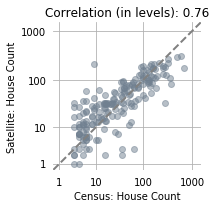

In [31]:
# hand-picked figures
plot_scatter(
    col_x_key='cen_house',
    col_x_label='Census: House Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
    xticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[1, 10, 100, 1000],
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    transform_y=lambda x: np.log10(x + 1),
    ylim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
    yticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    yticklabels=[1, 10, 100, 1000],
    square=True, df=df_group, out_dir=OUT_DIR, show=True)

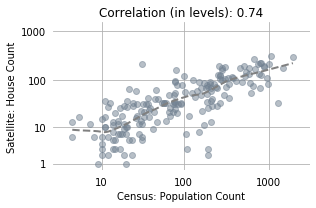

In [32]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(3), np.log10(3000)),
    xticks=[np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[10, 100, 1000],
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    transform_y=lambda x: np.log10(x + 1),
    ylim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
    yticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    yticklabels=[1, 10, 100, 1000],
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

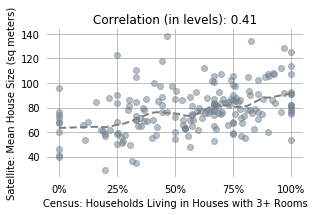

In [33]:
plot_scatter(
    col_x_key='cen_3plusroom',
    col_x_label='Census: Households Living in Houses with 3+ Rooms',
    xticks=[0, .25, .5, .75, 1],
    xticklabels=['0%', '25%', '50%', '75%', '100%'],
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size (sq meters)',
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

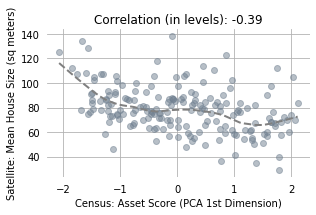

In [34]:
plot_scatter(
    col_x_key='cen_asset_score1',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size (sq meters)',
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

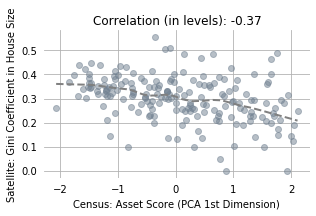

In [35]:
plot_scatter(
    col_x_key='cen_asset_score1',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    col_y_key='sat_size_gini',
    col_y_label='Satellite: Gini Coefficient in House Size',
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

In [36]:
model = smf.ols('cen_asset_score1 ~ sat_house + sat_size_mean + sat_dist_h05', data=df_group)
res = model.fit()
df_group['sat_asset_score1_pred'] = res.fittedvalues

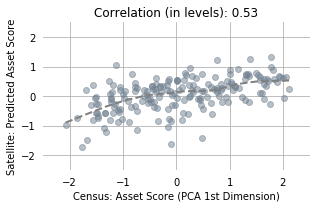

In [37]:
plot_scatter(
    col_x_key='cen_asset_score1',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    col_y_key='sat_asset_score1_pred',
    col_y_label='Satellite: Predicted Asset Score',
    xlim=(-2.5, 2.5),
    ylim=(-2.5, 2.5),
    line=True, df=df_group, out_dir=OUT_DIR, show=True)